In [1]:
from implicit_learning.trainer import PoissonTrainer 
from implicit_learning.model import  EoREN
from implicit_learning.dataset import PoissonEqn
from implicit_learning.utils import *
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader 

import torch
import matplotlib.pyplot as plt 


In [2]:
def construct_dataloader(config):
    sidelength = config['sidelength']
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

    train = PoissonEqn(config, transform=transform)
    valid = PoissonEqn(config, transform=transform)
    test  = PoissonEqn(config, transform=transform)
    
    train_dataloader =  DataLoader(train, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    valid_datalodaer =  DataLoader(valid, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    test_dataloader =   DataLoader(test, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)

    return train_dataloader, valid_datalodaer, test_dataloader


class CustomizeTrainer(PoissonTrainer):
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, config):
        super().__init__(model, train_dataloader, valid_dataloader, test_dataloader, config)

    def compute_loss(self, h,g,coords, alpha=0.3):
        edge_loss = self.gradients_mse(g, coords, self.gt['grads'])
        offset_loss = ((h - self.gt['pixels'])**2).mean() * 100000
         
        return (1-alpha) * edge_loss + alpha * offset_loss, edge_loss, offset_loss

    def train(self):
        for epoch in range(self.epochs):
            inputs = self.model_input

            self.optimizer.zero_grad() 
            h, g, coords =self.model(inputs)
            
            self.loss, edge, offset = self.compute_loss(h, g, coords, alpha=alpha) 

            if epoch % config.get("print_epoch") == 0:
                print("Epoch %4d"%(epoch), f" : Loss : {self.loss}, ",  edge, offset )
                img_grad = gradient(g, coords)
                self.plot(h, self.gt['pixels'], img_grad, self.gt)
            edge.backward()
            offset.backward()
            self.optimizer.step()

    def plot(self, model_output, original, img_grad, gt):
        fig, axes = plt.subplots(1, 4, figsize=(8, 3))
        axes[0].imshow(model_output.cpu().view(128,128).detach().numpy(), vmin=-1, vmax=1)
        axes[1].imshow(original.cpu().view(128,128).detach().numpy(), vmin=-1, vmax=1)
        axes[2].imshow(img_grad.cpu().norm(dim=-1).view(128,128).detach().numpy(), vmin=-5, vmax=5)
        axes[3].imshow(gt['grads'].cpu().norm(dim=-1).view(128,128).detach().numpy(), vmin=-5, vmax=5)
        plt.show()

Epoch    0  : Loss : 77313.3203125,  tensor(0.1046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(154626.5312, device='cuda:0', grad_fn=<MulBackward0>)


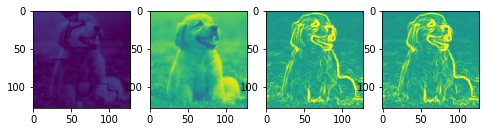

Epoch 2000  : Loss : 77363.671875,  tensor(0.0774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(154727.2656, device='cuda:0', grad_fn=<MulBackward0>)


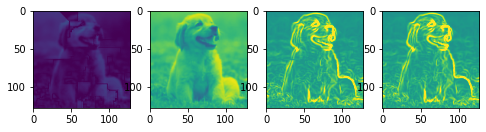

Epoch 4000  : Loss : 77445.296875,  tensor(0.0684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(154890.5312, device='cuda:0', grad_fn=<MulBackward0>)


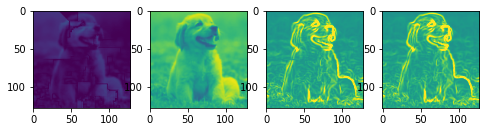

Epoch 6000  : Loss : 77527.671875,  tensor(0.0646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(155055.2812, device='cuda:0', grad_fn=<MulBackward0>)


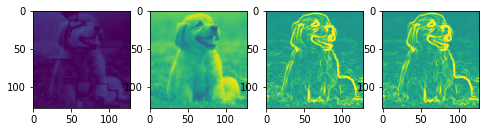

Epoch 8000  : Loss : 77455.171875,  tensor(0.0571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(154910.2812, device='cuda:0', grad_fn=<MulBackward0>)


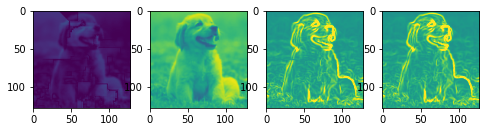

In [12]:

config = {
    "model":{
        "in_features":2,
        "hidden_features":256,
        "hidden_layers":3,
        "out_features":1
    },
    "sidelength":128,
    "epochs":100000,
    "lr":0.0001,
    "batch_size":1,
    "data-path":"../../data/dog224.png",
    "print_epoch":2000
}

# model = EoREN(**config['model'])
# model.cuda()
# trainer = CustomizeTrainer(model, *construct_dataloader(config), config)
# trainer.lr = 0.001
trainer.epochs = 10000
trainer.train()


ipykernel_launcher:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


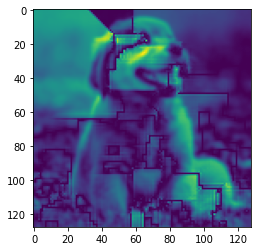

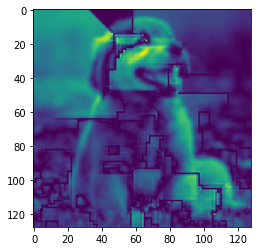

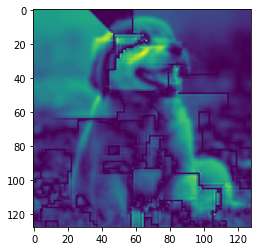

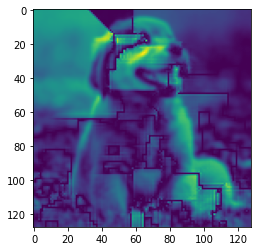

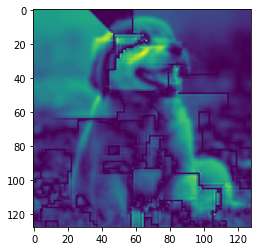

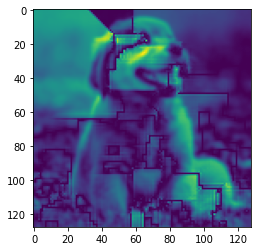

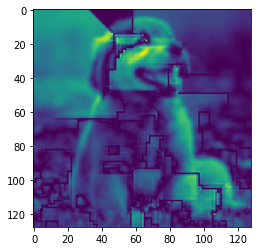

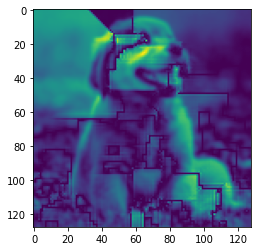

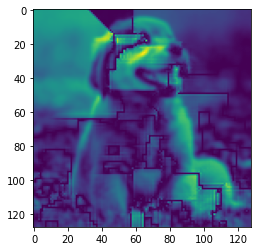

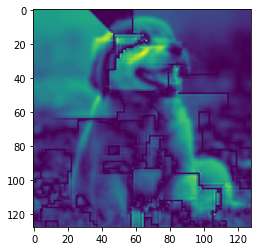

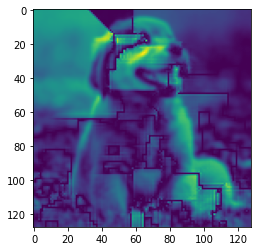

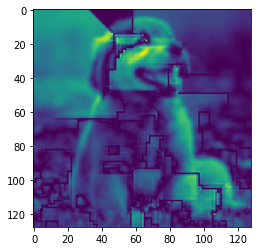

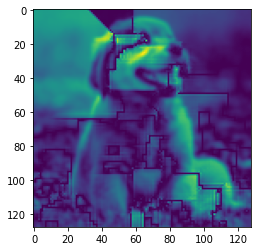

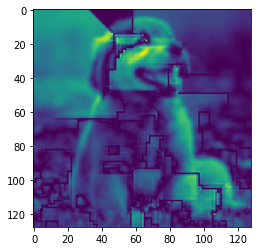

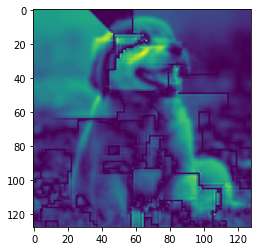

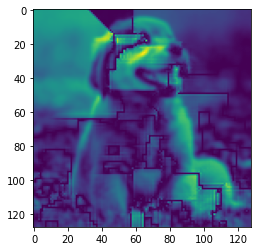

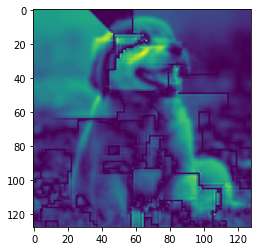

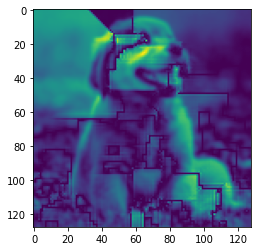

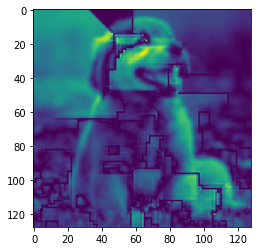

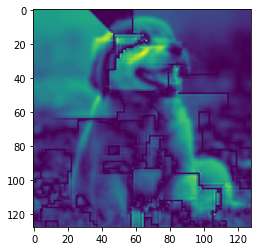

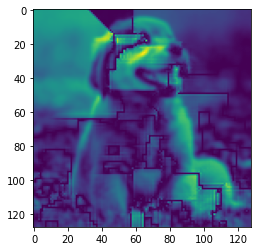

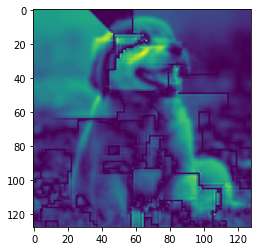

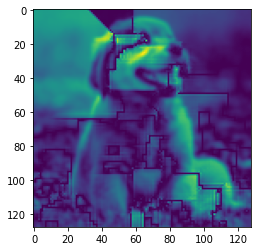

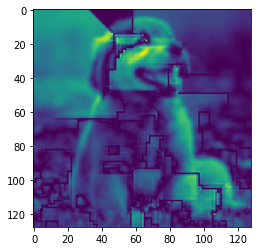

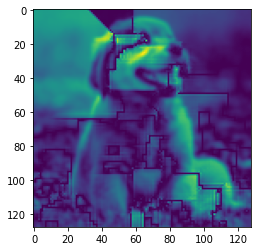

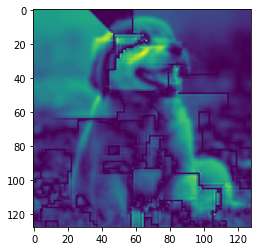

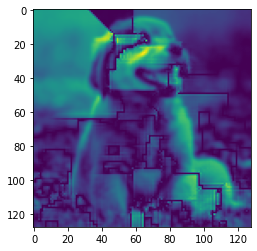

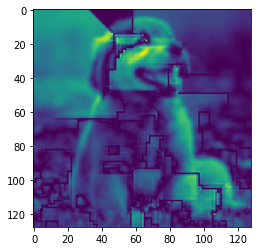

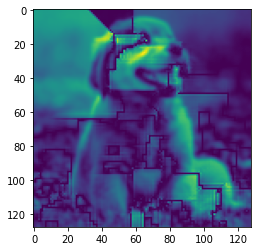

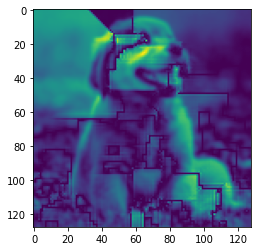

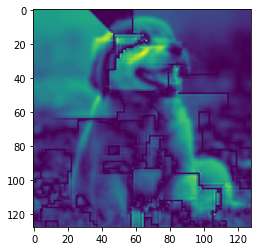

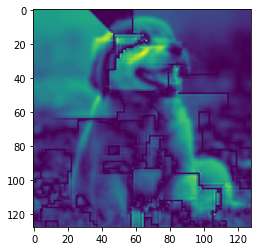

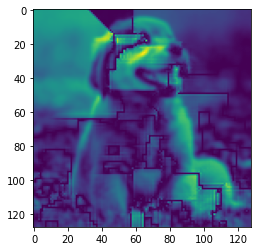

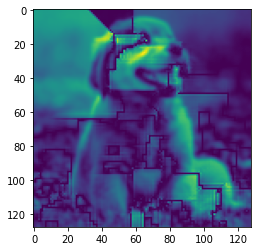

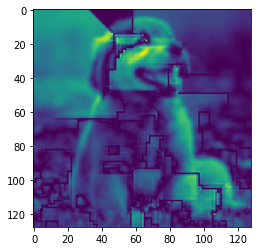

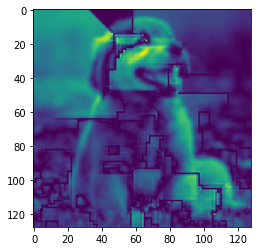

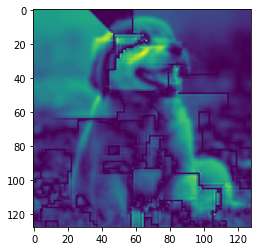

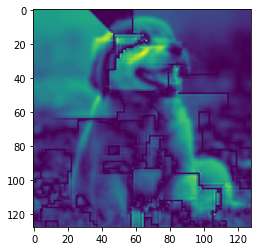

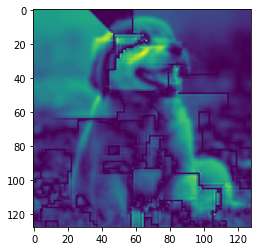

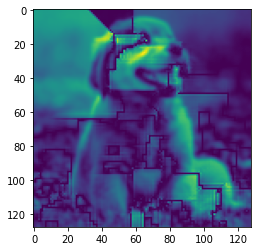

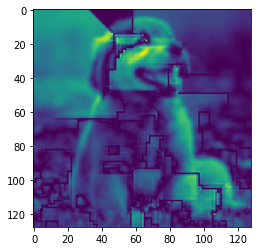

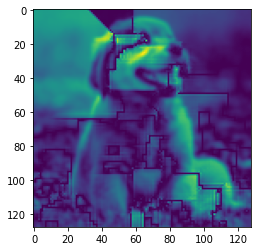

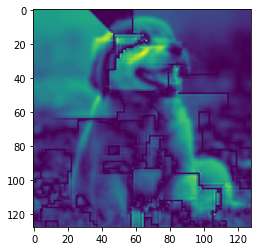

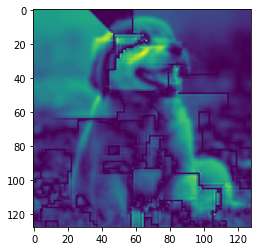

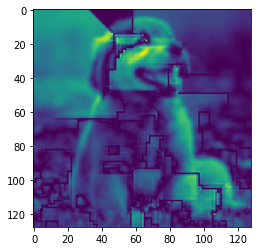

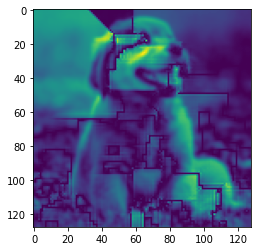

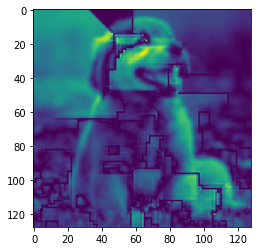

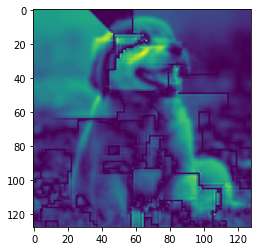

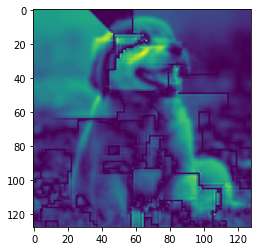

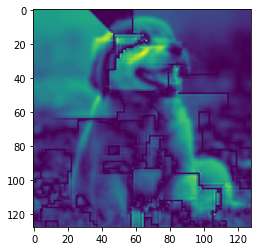

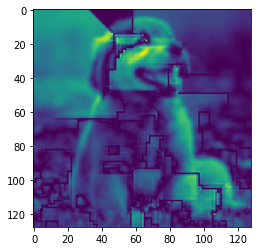

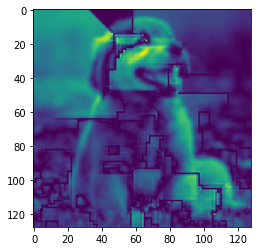

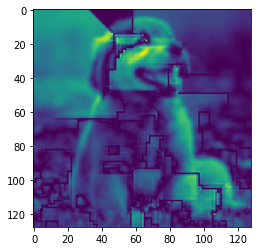

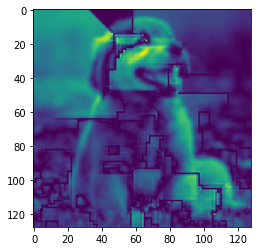

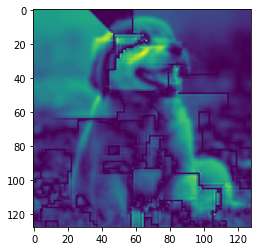

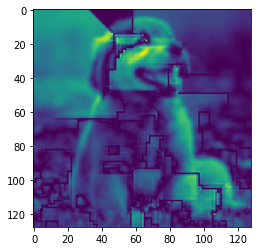

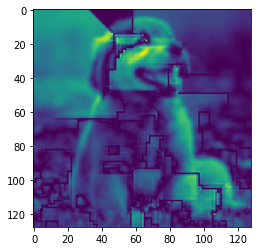

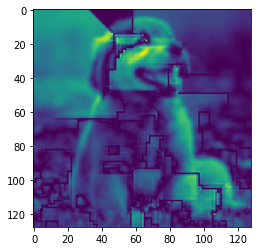

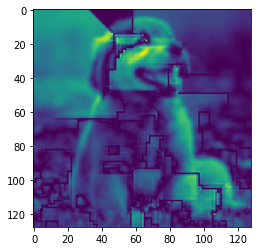

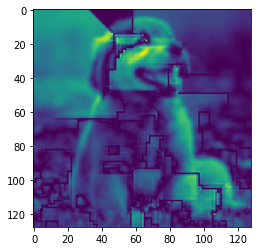

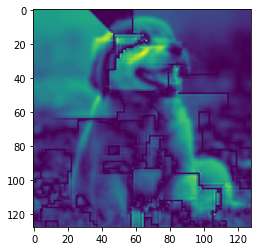

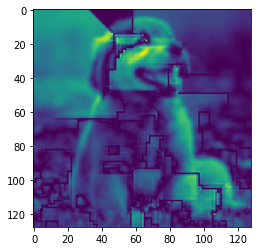

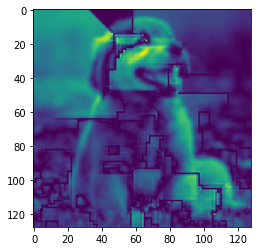

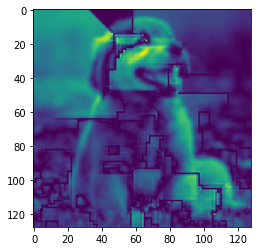

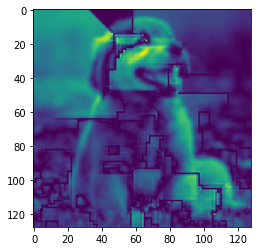

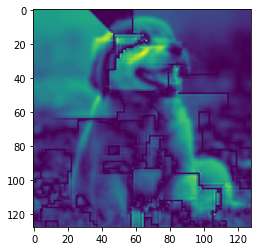

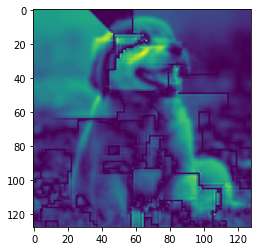

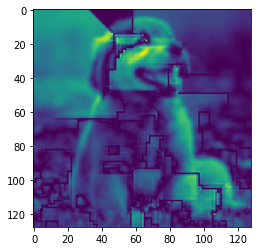

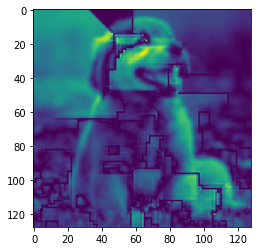

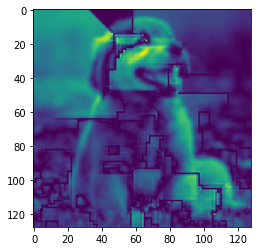

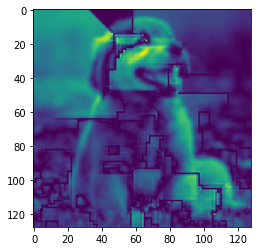

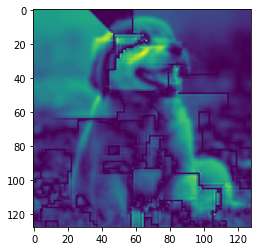

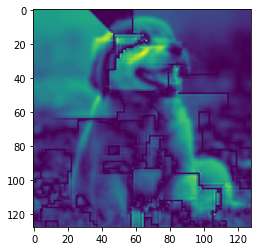

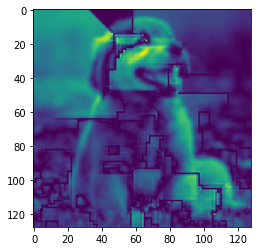

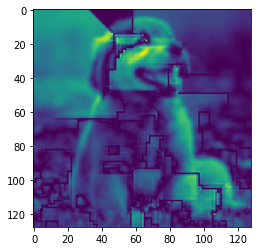

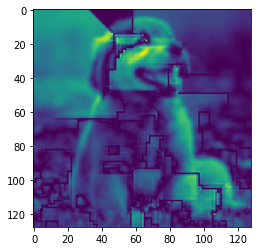

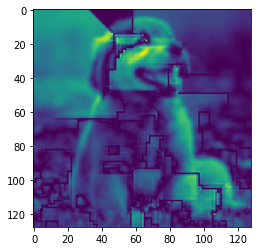

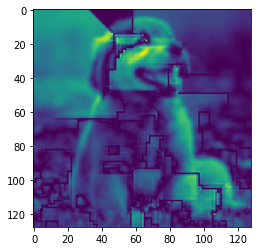

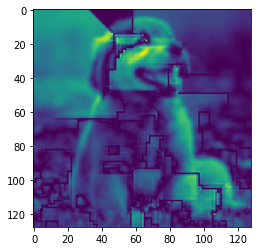

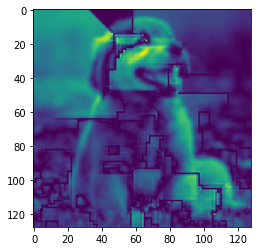

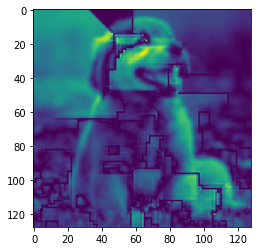

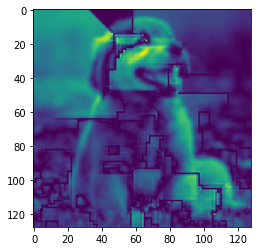

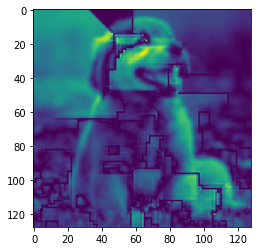

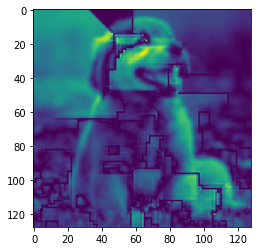

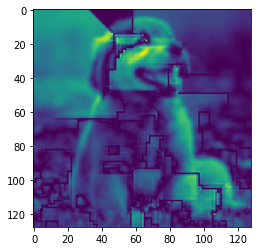

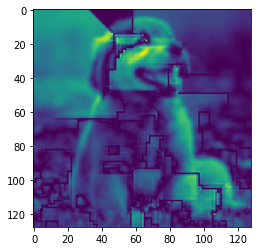

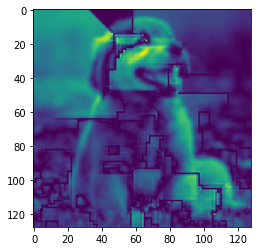

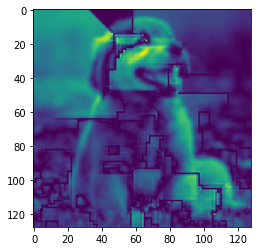

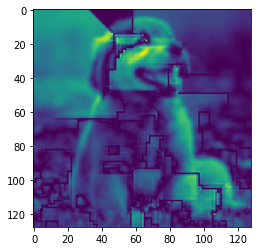

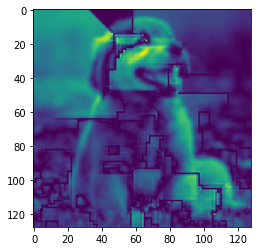

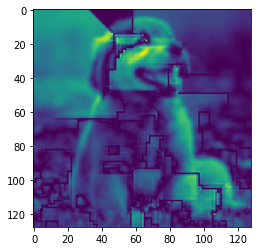

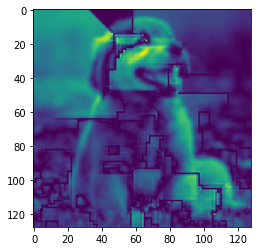

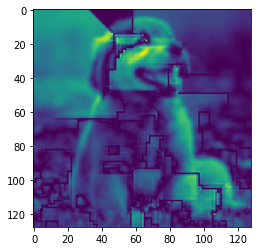

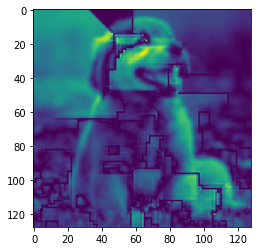

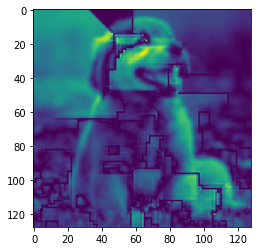

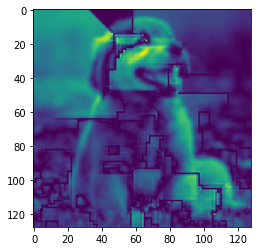

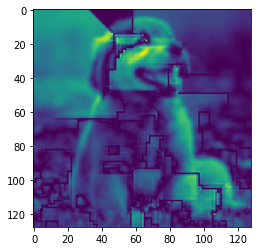

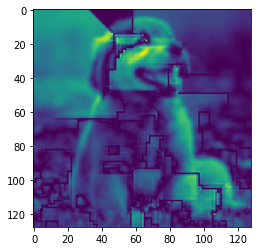

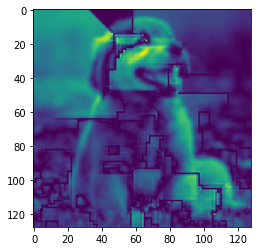

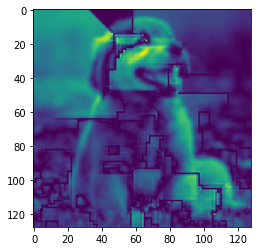

In [13]:
model_input = trainer.model_input 
image = trainer.model(model_input)
for b in np.linspace(-1,1,100):
    temp = image[0] + b 
    temp = temp.reshape(128,128).detach().cpu().numpy()
    plt.figure()
    plt.imshow(temp)

In [5]:
trainer.gt['grads'].size()

torch.Size([1, 16384, 2])